In [2]:
import keras
import numpy as np
import cv2
import pandas as pd
import os
from multiprocessing import Pool
from PIL import Image
#import modules
from utils import *
from vgg16bn import Vgg16BN
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
import time
import glob
import matplotlib.patches as patches

from scipy import stats
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle

img_path = '../data/train/'
%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: CUDA driver version is insufficient for CUDA runtime version)


In [3]:
'''
pip install kaggle-cli
kg config -g -u `username` -p `password` -c `the-nature-conservancy-fisheries-monitoring`

#kg download -u `username` -p `password` -c `the-nature-conservancy-fisheries-monitoring`
'''

'\npip install kaggle-cli\nkg config -g -u `username` -p `password` -c `the-nature-conservancy-fisheries-monitoring`\n\n#kg download -u `username` -p `password` -c `the-nature-conservancy-fisheries-monitoring`\n'

In [4]:
vgg = Vgg16BN()
model = vgg.model

/Users/patrickdalton/.pyenv/versions/miniconda2-latest/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [5]:
model.pop()
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [6]:
for layer in model.layers: layer.trainable=False

In [7]:
model.add(Dense(8, activation='softmax'))

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# this is a stupid way of using to_categorical, should just map the integer training labels.  oh well
categorical_labels = to_categorical(range(8), nb_classes=None)

In [10]:
def one_hot_to_cat(vector):
    return ints_to_cats[np.argmax(vector)]
def cat_to_one_hot(cat):
    return categorical_labels[cats_to_ints[cat]]

In [11]:
cats = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
cats_to_ints = {}
ints_to_cats = {}
for i, cat in enumerate(cats):
    cats_to_ints[cat] = i
    ints_to_cats[i] = cat

In [12]:
folders = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [13]:
folder = folders[0]

In [14]:
img = mpimg.imread(img_path+folder + '/img_00010.jpg')

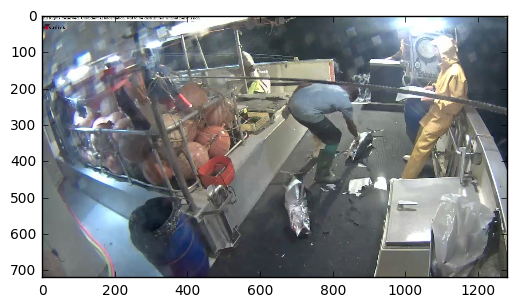

In [15]:
plt.imshow(img)

In [16]:
def load_train():
    X_train = []
    X_train_id = []
    y_train = []
    start_time = time.time()

    print('Read train images')
    folders = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
    for fld in folders:
        index = folders.index(fld)
        print('Load folder {} (Index: {})'.format(fld, index))
        path = os.path.join('../data/train', fld, '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_pil(fl)
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(cat_to_one_hot(fld))

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return np.array(X_train), np.array(y_train), X_train_id


def load_test():
    path = os.path.join('..', 'input', 'test_stg1', '*.jpg')
    files = sorted(glob.glob(path))

    X_test = []
    X_test_id = []
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_pil(fl)
        X_test.append(img)
        X_test_id.append(flbase)

    return X_test, X_test_id

def get_im_pil(path):
    img = Image.open(path)
    img_resized = img.resize((224,224), resample=Image.LANCZOS)
    #resized = img.convert('L')
    return np.array(img_resized).reshape(3,224,224)

In [17]:
X_train, Y_train, c = load_train()

Read train images
Load folder ALB (Index: 0)
Load folder BET (Index: 1)
Load folder DOL (Index: 2)
Load folder LAG (Index: 3)
Load folder NoF (Index: 4)
Load folder OTHER (Index: 5)
Load folder SHARK (Index: 6)
Load folder YFT (Index: 7)
Read train data time: 186.54 seconds


In [18]:
X, Y = shuffle(X_train, Y_train, random_state = 3)


In [19]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]
save_array('../data/train/train_x', X)
save_array('../data/train/train_y', Y)

In [ ]:
X = load_array('../data/train/train_x')
Y = load_array('../data/train/train_y')

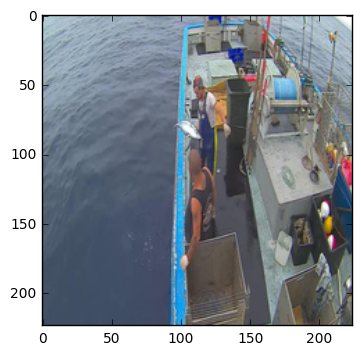

In [29]:
plt.imshow(X[6].reshape((224,224,3)))

In [30]:
Y[:]

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]])

In [ ]:
#stats.describe([x.shape for x in a])

Based on the description of the shapes of the array, we are going to resize all of them to 342 by 600.  That's because the height to width ratio was typically .57

In [20]:
model.fit(X, Y, nb_epoch=1, shuffle=True, batch_size=64, verbose=1, callbacks=[], validation_split=.08)

Train on 3474 samples, validate on 303 samples
Epoch 1/1
1344/3474 [==========>...................] - ETA: 1100s - loss: 3.7106 - acc: 0.3460

KeyboardInterrupt: 

array([[ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.]])

In [70]:
# Bounding Boxes

class BBox(object):
    
    def __init__(self, annotation):
        self.shape = annotation['class']
        self.h = annotation['height']
        self.w = annotation['width']
        self.left = max(0,annotation['x'])
        self.top = max(0,annotation['y'])
        self.bottom = self.top + self.h
        self.right = self.left + self.w
        
    def get_shape(self):
        return self.left, self.top, self.right, self.bottom


class Sloth(object):
    
    def __init__(self, json_object, cla):
        self.filename = json_object['filename']
        self.classification = cla
        self.bboxes = []
        for annotation in json_object['annotations']:
            self.bboxes.append(BBox(annotation))
            

def get_bounding_boxes():
    
    folders = ['ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
    info = {}

    for fld in folders:
        index = folders.index(fld)
        print('Load folder {} (Index: {})'.format(fld, index))
        path = os.path.join('../data/annotations', fld.lower() + '_labels.json')
        with open(path, 'r') as jf:
            info[fld] = json.load(jf)
            
    return info
            
def to_sloth(info):
    
    sloths = {}
    for classification, markups in info.iteritems():
        sloths[classification] = []
        for markup in markups:
            sloths[classification].append(Sloth(markup, classification))
            
    return sloths

In [71]:
info = get_bounding_boxes()
sloths = to_sloth(info)

Load folder ALB (Index: 0)
Load folder BET (Index: 1)
Load folder DOL (Index: 2)
Load folder LAG (Index: 3)
Load folder OTHER (Index: 4)
Load folder SHARK (Index: 5)
Load folder YFT (Index: 6)


In [111]:
def plot_sloth(sl):
    print sl.filename
    fig, ax = plt.subplots(1)
    show_image_from_sloth(ax,sl)
    for bbox in sl.bboxes:
        ax.add_patch(
            patches.Rectangle(
                (bbox.left, bbox.top), bbox.w, bbox.h,linewidth=1,
                fill=False, edgecolor="red"      # remove background
            )
        )
    plt.show()


NEW CLASS SHARK
../data/train/SHARK/img_07860.jpg


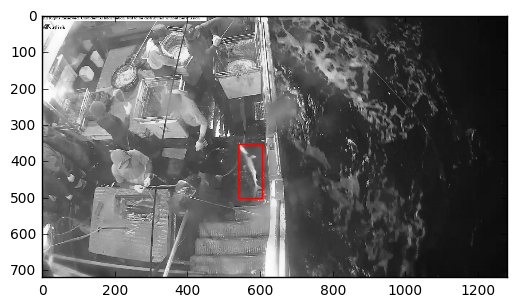

NEW CLASS SHARK
../data/train/SHARK/img_07857.jpg


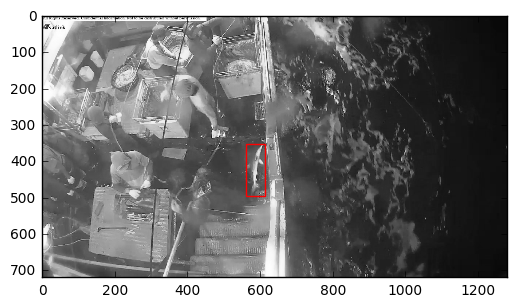

NEW CLASS DOL
img_07898.jpg


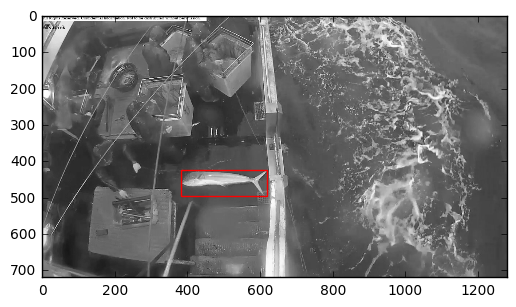

NEW CLASS DOL
img_07728.jpg


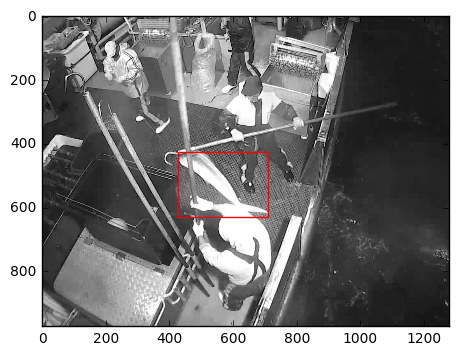

NEW CLASS LAG
img_07919.jpg


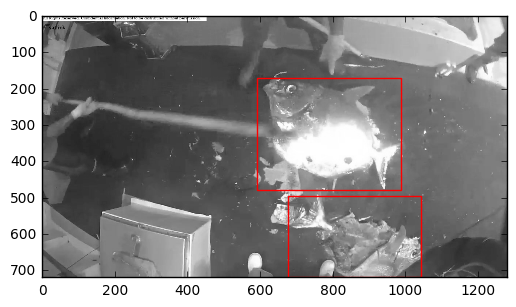

NEW CLASS LAG
img_07830.jpg


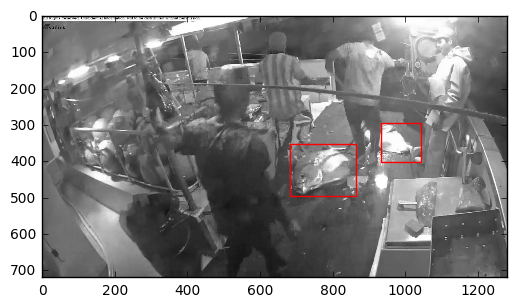

NEW CLASS ALB
img_07917.jpg


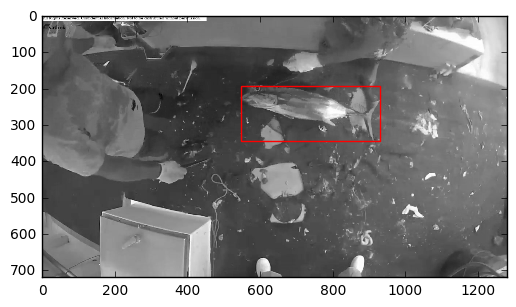

NEW CLASS ALB
img_07915.jpg


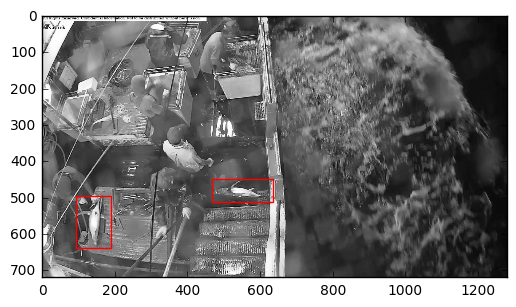

NEW CLASS YFT
../data/train/YFT/img_07911.jpg


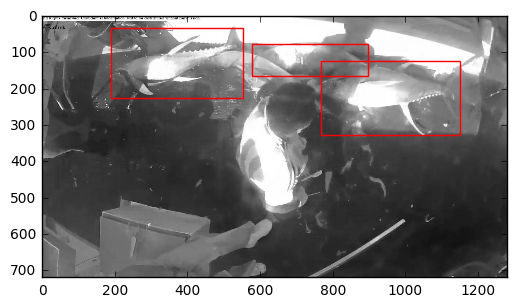

NEW CLASS YFT
../data/train/YFT/img_07901.jpg


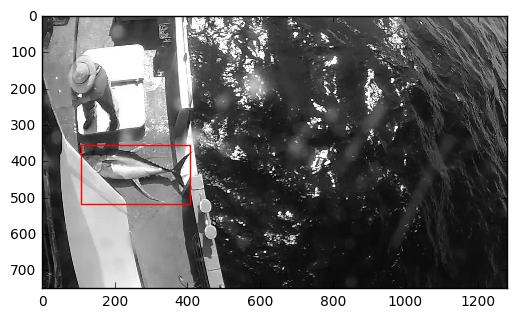

NEW CLASS OTHER
../data/train/OTHER/img_07923.jpg


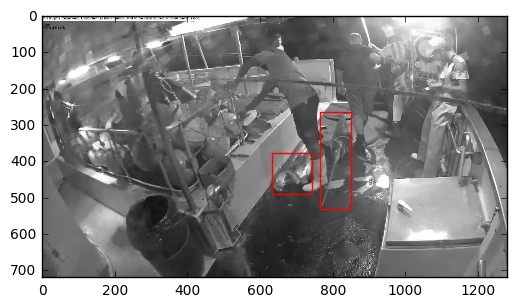

NEW CLASS OTHER
../data/train/OTHER/img_07922.jpg


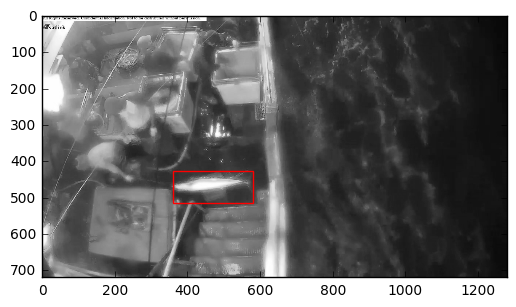

NEW CLASS BET
img_07825.jpg


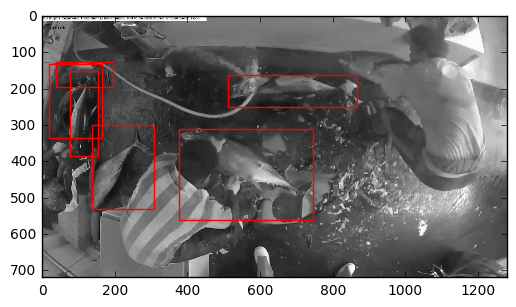

NEW CLASS BET
img_07804.jpg


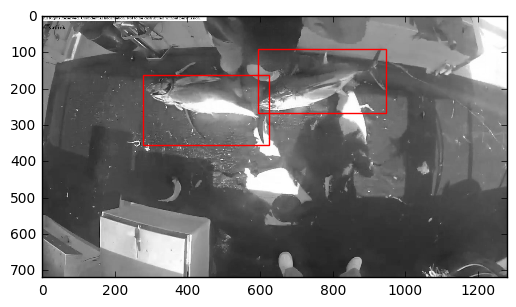

In [114]:
for sloth in sloths:
    for i in range(2):
        print sloth
        plot_sloth(sloths[sloth][i])

Now that we've seen some examples of bounding boxes around the fish, let's look at the average size of the bounding box.  This will help us with our sliding window approach.

In [121]:
h_arr, w_arr = [], []
for sloth_arr in sloths.values():
    for sloth in sloth_arr:
        for bbox in sloth.bboxes:
            h_arr.append(bbox.h)
            w_arr.append(bbox.w)


In [123]:
df = pd.DataFrame()

In [124]:
df['height'] = h_arr
df['width'] = w_arr

In [126]:
df.describe()

,height,width
count,4471.000000,4471.000000
mean,151.229732,220.077275
std,65.961158,126.502746
min,20.186382,17.811513
25%,105.750000,118.743421
50%,141.304671,190.350000
75%,184.000000,311.107763
max,478.000000,811.017565
